# Implementation of GAN for MNIST digit generation for Sony CSL internship

This is a simple implementation of a GAN, cGAN, AEGAN and e-cGAN in pytorch for MNIST digit generation


## Requirements

We begin by importing the required libraries and the MNIST dataset, while defining the key global hyperparameters


In [43]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Global hyperparameters
batch_size = 64
device = torch.device("mps")

# GAN Loss function
loss = nn.BCELoss()

# Encoder Loss function
loss_enc = nn.MSELoss()

# MNIST is grayscale, so 1 channel
img_channel = 1

# label for real and fake images
real_val = 1
fake_val = 0

# Import dataset, normalise and load into dataloader
mnist = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

dataloader = torch.utils.data.DataLoader(
    mnist, batch_size=batch_size, shuffle=True, num_workers=2
)

Next we'll just print some examples of the MNIST dataset to see what we're working with

tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1

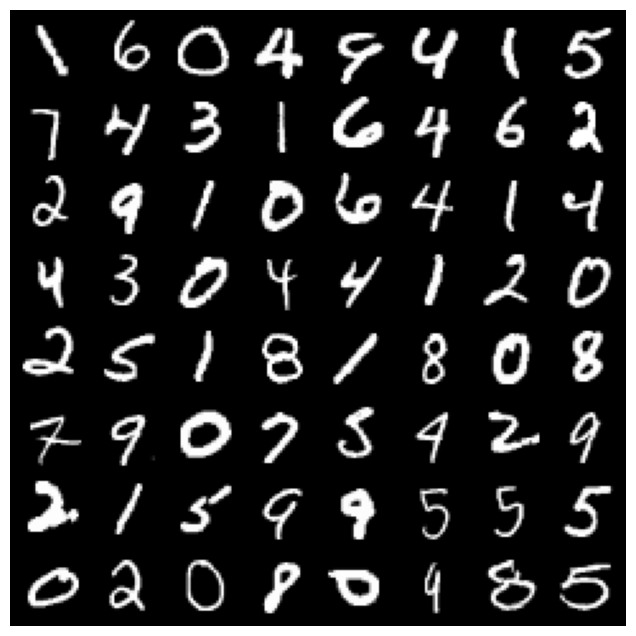

In [18]:
examples = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
grid = np.transpose(
    torchvision.utils.make_grid(examples[0][:64], padding=2, normalize=True),
    (1, 2, 0),
)
plt.imshow(grid)

## Vanilla Generative Adversarial Network (GAN)


In [10]:
class Generator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh(),
        )

    def forward(self, z):
        return self.model(z)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel

        self.model = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [11]:
# Model Hyperparameters
latent_dim = 100
hidden_dim = 64

# Initialise generator and discriminator
generator = Generator(
    hidden_dim, latent_dim, img_channel).to(device)
print(generator)

discriminator = Discriminator(
    hidden_dim, img_channel).to(device)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (11): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [15]:
def dis_train_step(batch_size, gen, dis, dis_optimiser, loss, real_img):
    # Clear Gradients
    dis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    d_loss = real_loss + fake_loss
    d_loss.backward()
    dis_optimiser.step()
    return d_loss.item()

In [14]:
def gen_train_step(batch_size, gen, dis, gen_optimiser, loss):
    # Clear Gradients
    gen_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    fake = gen(noise)
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)

    # Update Weights
    g_loss.backward()
    gen_optimiser.step()
    return g_loss.item()

Epoch 1


g_loss: 2.073059558868408, d_loss: 1.0688725709915161: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s] 

Final Avg: g_loss: 1.4907978989168016, d_loss: 0.9571089130093549


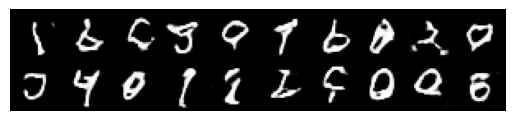

Epoch 2


g_loss: 1.8928091526031494, d_loss: 0.7483370304107666: 100%|██████████| 938/938 [01:04<00:00, 14.51it/s]

Final Avg: g_loss: 1.5013816187630837, d_loss: 0.9621137890861486


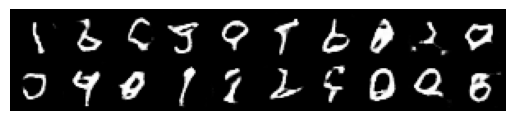

Epoch 3


g_loss: 0.9892836809158325, d_loss: 0.9403300285339355: 100%|██████████| 938/938 [01:05<00:00, 14.32it/s]

Final Avg: g_loss: 1.5135787661268767, d_loss: 0.9677753692496814


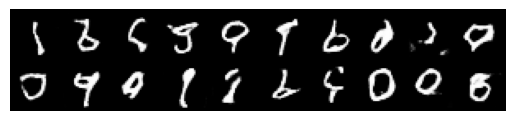

Epoch 4


g_loss: 1.4396628141403198, d_loss: 0.8602540493011475: 100%|██████████| 938/938 [01:07<00:00, 13.93it/s]

Final Avg: g_loss: 1.5099311259382568, d_loss: 0.96870535751904


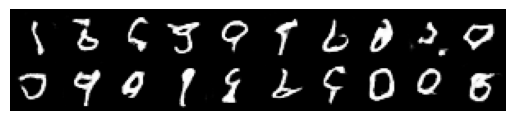

Epoch 5


g_loss: 1.3240251541137695, d_loss: 0.9886659383773804: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s]

Final Avg: g_loss: 1.5040261008337872, d_loss: 0.990203395962461


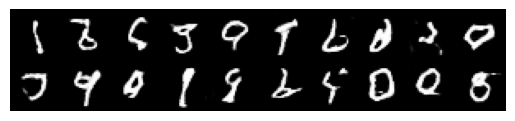

Epoch 6


g_loss: 1.0961735248565674, d_loss: 0.7855899333953857: 100%|██████████| 938/938 [01:08<00:00, 13.73it/s]

Final Avg: g_loss: 1.4746686358695853, d_loss: 0.9904151323761767


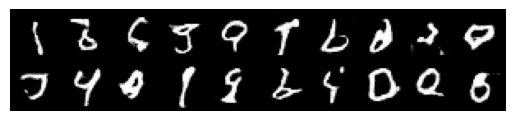

Epoch 7


g_loss: 1.239221453666687, d_loss: 0.8551262617111206: 100%|██████████| 938/938 [01:07<00:00, 13.81it/s] 

Final Avg: g_loss: 1.4562737883281098, d_loss: 1.0014146150810632


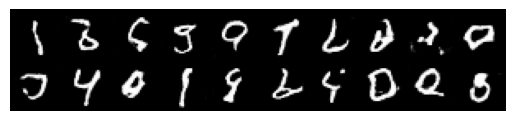

Epoch 8


g_loss: 1.0492879152297974, d_loss: 1.1159716844558716: 100%|██████████| 938/938 [01:06<00:00, 14.07it/s]

Final Avg: g_loss: 1.447076028947637, d_loss: 1.0110231186789491


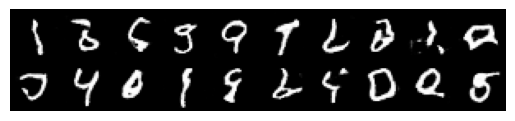

Epoch 9


g_loss: 1.2572636604309082, d_loss: 0.8616981506347656: 100%|██████████| 938/938 [01:06<00:00, 14.01it/s]

Final Avg: g_loss: 1.430078922558441, d_loss: 1.0211947701378925


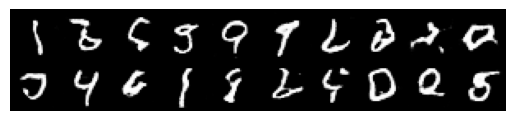

Epoch 10


g_loss: 1.4698303937911987, d_loss: 1.0259253978729248: 100%|██████████| 938/938 [01:05<00:00, 14.24it/s]

Final Avg: g_loss: 1.4185127967964613, d_loss: 1.0268422552644572


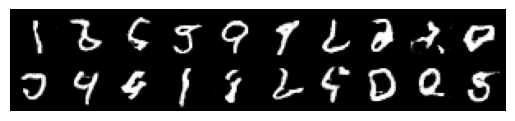

Epoch 11


g_loss: 1.1563165187835693, d_loss: 1.1376687288284302: 100%|██████████| 938/938 [01:08<00:00, 13.78it/s]

Final Avg: g_loss: 1.4040874796254295, d_loss: 1.0377823373020838


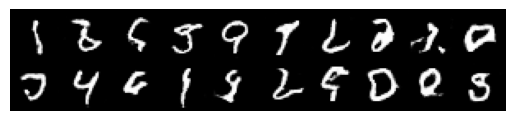

Epoch 12


g_loss: 0.8388857841491699, d_loss: 1.0550909042358398: 100%|██████████| 938/938 [01:05<00:00, 14.28it/s]

Final Avg: g_loss: 1.3818238919604815, d_loss: 1.0560918483398616


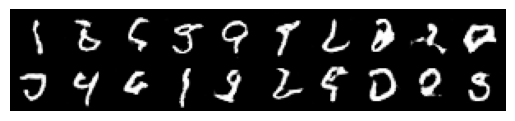

Epoch 13


g_loss: 0.9731249809265137, d_loss: 1.0422422885894775: 100%|██████████| 938/938 [01:07<00:00, 13.99it/s]

Final Avg: g_loss: 1.368003981454032, d_loss: 1.0556576426730735


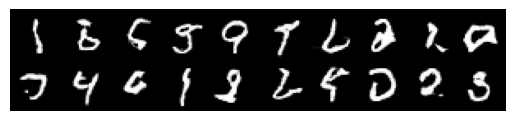

Epoch 14


g_loss: 1.647265911102295, d_loss: 0.8281887769699097: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s] 

Final Avg: g_loss: 1.3477533118429976, d_loss: 1.0729750703011494


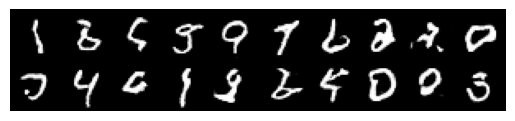

Epoch 15


g_loss: 0.6585221290588379, d_loss: 0.8368555307388306: 100%|██████████| 938/938 [01:05<00:00, 14.22it/s]

Final Avg: g_loss: 1.331552889841452, d_loss: 1.0733642051341945


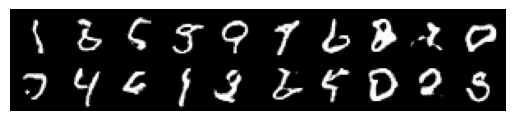

Epoch 16


g_loss: 1.709388256072998, d_loss: 1.1005396842956543: 100%|██████████| 938/938 [01:07<00:00, 13.83it/s] 

Final Avg: g_loss: 1.3109413281813869, d_loss: 1.0885097923944753


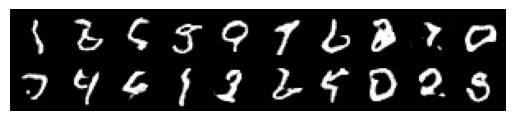

Epoch 17


g_loss: 1.3101749420166016, d_loss: 1.0499439239501953: 100%|██████████| 938/938 [01:06<00:00, 14.20it/s]

Final Avg: g_loss: 1.315867457181406, d_loss: 1.088151416862443


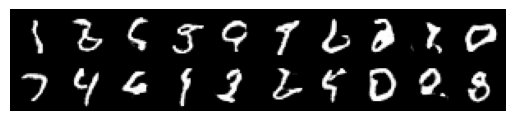

Epoch 18


g_loss: 0.813819944858551, d_loss: 1.2185046672821045: 100%|██████████| 938/938 [01:05<00:00, 14.29it/s] 

Final Avg: g_loss: 1.283502125663798, d_loss: 1.1046673219595382


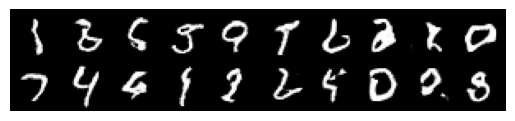

Epoch 19


g_loss: 1.1634314060211182, d_loss: 1.0595476627349854: 100%|██████████| 938/938 [01:07<00:00, 13.88it/s]

Final Avg: g_loss: 1.2673725278646961, d_loss: 1.1134792225066024


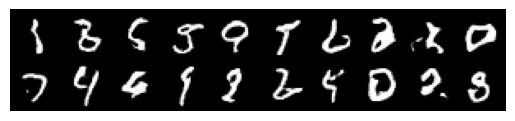

Epoch 20


g_loss: 1.5544902086257935, d_loss: 1.080775499343872: 100%|██████████| 938/938 [01:07<00:00, 13.94it/s] 

Final Avg: g_loss: 1.247914845056371, d_loss: 1.1242963252291243


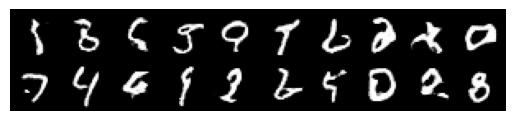

Epoch 21


g_loss: 1.3317859172821045, d_loss: 1.0228193998336792: 100%|██████████| 938/938 [01:05<00:00, 14.28it/s]

Final Avg: g_loss: 1.225480122670436, d_loss: 1.1408900035215592


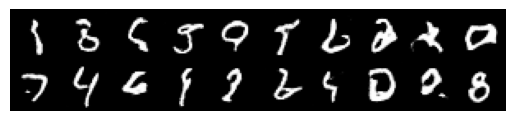

Epoch 22


g_loss: 1.7184741497039795, d_loss: 1.0497369766235352:  20%|██        | 190/938 [00:14<00:55, 13.56it/s]


KeyboardInterrupt: 

In [20]:
# total number of epochs to train the model
num_epochs = 25

# constant inputs for visualisation
test_noise = torch.randn(20, 100, device=device)

# optimisers
lr = 0.0002
dis_optimiser = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
gen_optimiser = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    dis_loss_sum = 0
    gen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        generator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        dis_loss = dis_train_step(
            batch_size, generator, discriminator, dis_optimiser, loss, real_img
        )

        # Train generator
        gen_loss = gen_train_step(
            batch_size, generator, discriminator, gen_optimiser, loss
        )

        # Update running loss
        dis_loss_sum += dis_loss
        gen_loss_sum += gen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(gen_loss, dis_loss)
            )

    # average loss over epoch
    print(
        "Final Avg: g_loss: {}, d_loss: {}".format(
            gen_loss_sum / len(dataloader), dis_loss_sum / len(dataloader)
        )
    )
    generator.eval()

    # visualise generated images
    sample_images = generator(test_noise).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Conditional GAN (cGAN)

We will encode our classes as embedding layers then scale them using a linear layer to act as a separate image channel.

In [22]:
class ConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )

    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)

In [23]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, hidden_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Linear(49, 784),
            nn.Unflatten(1, (1, 28, 28))
        )

        self.downsample = nn.Sequential(
            # First downsample layer (to 14x14)
            nn.Conv2d(img_channel + 1, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            # Second downsample layer (to 7x7)
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Output
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(hidden_dim * 2 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        y = self.label_embedding(y)
        x = torch.cat((x, y), dim=1)
        return self.downsample(x)

In [24]:
# Model Hyperparameters
latent_dim = 100
hidden_dim = 64
num_classes = 10

# Initialise Conditional Generator and Discriminator
cgenerator = ConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
print(cgenerator)

cdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
print(cdiscriminator)

ConditionalGenerator(
  (label_embedding): Sequential(
    (0): Embedding(10, 49)
    (1): Unflatten(dim=1, unflattened_size=(1, 7, 7))
  )
  (reshape_noise): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
  )
  (upsample): Sequential(
    (0): ConvTranspose2d(257, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (7): Tanh()
  )
)
ConditionalD

In [25]:
def cdis_train_step(batch_size, cgen, cdis, cdisoptimiser, loss, real_img, labels):
    # Clear Gradients
    cdisoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)  
    fake_labels = torch.randint(0, 10, (batch_size,), device=device) 
    fake = cgen(noise, fake_labels)
    validity = cdis(fake, fake_labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    cd_loss = real_loss + fake_loss 
    cd_loss.backward()
    cdisoptimiser.step() 
    return cd_loss.item()

In [26]:
def cgen_train_step(batch_size, cgen, cdis, cgenoptimiser, loss):
    # Clear Gradients
    cgenoptimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    noise = torch.randn(batch_size, 100, device=device)
    labels = torch.randint(0, 10, (batch_size,), device=device)
    fake = cgen(noise, labels)
    validity = cdis(fake, labels).squeeze(-1)
    cg_loss = loss(validity, real_vals)

    # Update Weights
    cg_loss.backward()
    cgenoptimiser.step()
    return cg_loss.item()

Epoch 1


g_loss: 3.644941806793213, d_loss: 0.09639329463243484: 100%|██████████| 938/938 [01:11<00:00, 13.21it/s] 

Final: g_loss: 2.980199258401196, d_loss: 0.3842483408042172


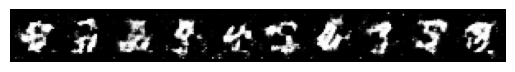

Epoch 2


g_loss: 2.029090166091919, d_loss: 0.4190632700920105: 100%|██████████| 938/938 [01:09<00:00, 13.47it/s]  

Final: g_loss: 2.6499821017545933, d_loss: 0.48787261683470023


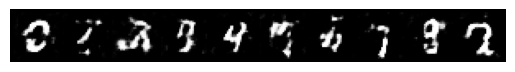

Epoch 3


g_loss: 3.1871933937072754, d_loss: 0.7892640829086304: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s] 

Final: g_loss: 2.4244717879971462, d_loss: 0.5272815681692126


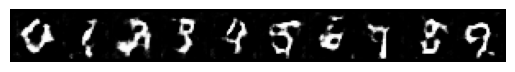

Epoch 4


g_loss: 1.310502529144287, d_loss: 0.925771951675415: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s]   

Final: g_loss: 2.362304696904571, d_loss: 0.6007680226999051


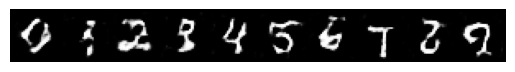

Epoch 5


g_loss: 3.252817153930664, d_loss: 1.324408769607544: 100%|██████████| 938/938 [01:09<00:00, 13.40it/s]  

Final: g_loss: 2.2692658612723036, d_loss: 0.6596837854588719


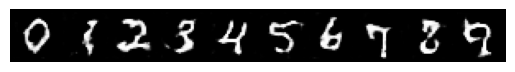

Epoch 6


g_loss: 2.459425449371338, d_loss: 0.7040181159973145: 100%|██████████| 938/938 [01:09<00:00, 13.46it/s]  

Final: g_loss: 2.199485542042169, d_loss: 0.7080512731504847


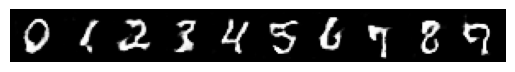

Epoch 7


g_loss: 2.199984073638916, d_loss: 0.5536664128303528: 100%|██████████| 938/938 [01:08<00:00, 13.71it/s]  

Final: g_loss: 2.1873927246342335, d_loss: 0.7217218490805961


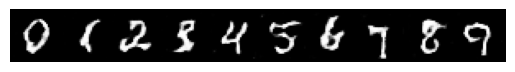

Epoch 8


g_loss: 2.2046005725860596, d_loss: 0.4278721809387207: 100%|██████████| 938/938 [01:08<00:00, 13.64it/s]

Final: g_loss: 2.1478548652327647, d_loss: 0.7413021078559635


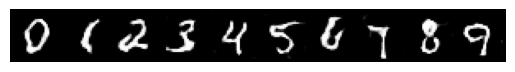

Epoch 9


g_loss: 2.704622745513916, d_loss: 0.8006857633590698: 100%|██████████| 938/938 [01:08<00:00, 13.72it/s] 

Final: g_loss: 2.1381511821040213, d_loss: 0.7616492599757241


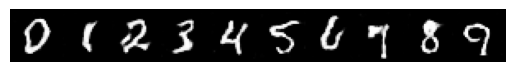

Epoch 10


g_loss: 1.8014895915985107, d_loss: 0.7939102053642273: 100%|██████████| 938/938 [01:08<00:00, 13.73it/s]

Final: g_loss: 2.1116552545444796, d_loss: 0.769005080847852


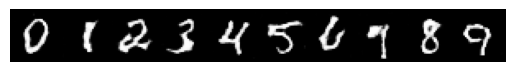

In [27]:
# total number of epochs to train the model
num_epochs = 10

# constant inputs for visualisation
test_noise = torch.randn(10, 100, device=device)
test_labels = torch.LongTensor(np.arange(10)).to(device)

# optimisers
lr = 0.0002
cdis_optimiser = torch.optim.Adam(cdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))
cgen_optimiser = torch.optim.Adam(cgenerator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    cdis_loss_sum = 0
    cgen_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, label) in data_iter:
        # Prepare batch
        real_img = images.to(device)
        labels = label.to(device)
        cgenerator.train()
        batch_size = real_img.shape[0]

        # Train discriminator
        cdis_loss = cdis_train_step(
            batch_size, cgenerator, cdiscriminator, cdis_optimiser, loss, real_img, labels,
        )

        # Train generator
        cgen_loss = cgen_train_step(
            batch_size, cgenerator, cdiscriminator, cgen_optimiser, loss
        )

        # Update running loss
        cdis_loss_sum += cdis_loss
        cgen_loss_sum += cgen_loss
        if i % 50 == 0:
            data_iter.set_description(
                "g_loss: {}, d_loss: {}".format(cgen_loss, cdis_loss)
            )

    # average loss over epoch
    print(
        "Final: g_loss: {}, d_loss: {}".format(
            cgen_loss_sum / len(dataloader), cdis_loss_sum / len(dataloader)
        )
    )
    cgenerator.eval()

    # visualise generated images
    sample_images = cgenerator(test_noise, test_labels).cpu()
    grid = (
        torchvision.utils.make_grid(sample_images, nrow=10, padding=2, normalize=True)
        .permute(1, 2, 0)
        .numpy()
    )
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Auto Encoder GAN (AEGAN)

In [36]:
class AutoEncoderGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel

        # Encoder that produces a 100-dimensional latent vector from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, latent_dim)
        ) 

        self.model = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7)),
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z):
        z = self.encoder(z)
        return self.model(z)

In [37]:
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64

# Initialise Encoder Conditional Generator and Discriminator
aegenerator = AutoEncoderGenerator(
    hidden_dim, latent_dim, img_channel).to(device)
print(aegenerator)

aediscriminator = Discriminator(
    hidden_dim, img_channel).to(device)
print(aediscriminator)

AutoEncoderGenerator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=10, bias=True)
  )
  (model): Sequential(
    (0): Linear(in_features=10, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, 

In [38]:
def aedis_train_step(batch_size, aegen, dis, aedis_optimiser, loss, real_img):
    # Clear Gradients
    aedis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = dis(real_img).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = aegen(real_img)
    validity = dis(fake).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    dloss = real_loss + fake_loss 
    dloss.backward() 
    aedis_optimiser.step() 
    return dloss.item() 

In [39]:
def aegen_train_step(batch_size, aegen, dis, aegen_optimiser, loss, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake = aegen(real_img) 
    validity = dis(fake).squeeze(-1)
    g_loss = loss(validity, real_vals)
    e_loss = loss_enc(real_img, fake) 
    
    # Update Weights
    aeg_loss = g_loss + e_loss  
    aeg_loss.backward()  
    aegen_optimiser.step()  
    return aeg_loss.item()  

In [40]:
def enc_train_step(ecgen, aegen_optimiser, loss_enc, real_img):
    # Clear Gradients
    aegen_optimiser.zero_grad() 

    # Train on reconstruction
    fake = ecgen(real_img) 
    e_loss = loss_enc(real_img, fake)
    
    # Update Weights
    e_loss.backward() 
    aegen_optimiser.step() 
    return e_loss.item() 

Epoch 1


enc_loss: 0.08296006917953491: 100%|██████████| 938/938 [00:32<00:00, 29.10it/s]

Final Avg: enc_loss: 0.11332358064046547


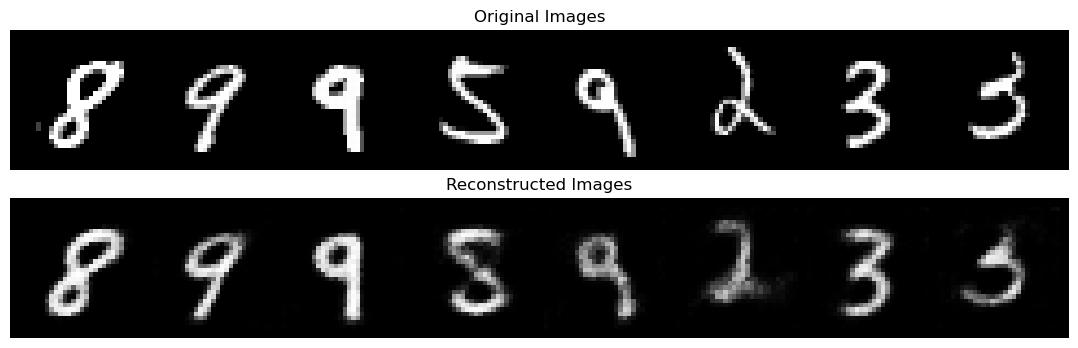

Epoch 2


g_loss: 0.9196474552154541, d_loss: 1.3367395401000977: 100%|██████████| 938/938 [01:09<00:00, 13.40it/s]

Final Avg: g_loss: 0.922628352192165, d_loss: 1.3935080569690224


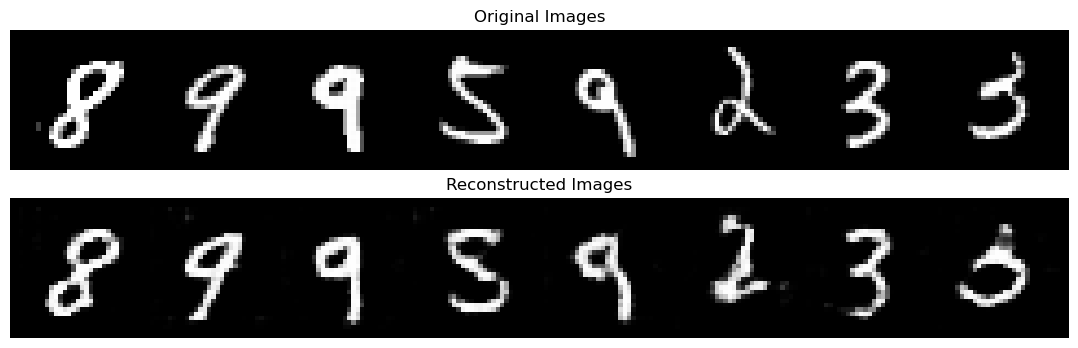

Epoch 3


g_loss: 0.8374475240707397, d_loss: 1.3298428058624268:   8%|▊         | 75/938 [00:06<01:12, 11.90it/s]


KeyboardInterrupt: 

In [44]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 1

# Constant images for visualisation
test_imgs = next(iter(dataloader))[0][:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(aegenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(aediscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, _) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        aegenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss = enc_train_step(
                aegenerator, ecgen_optimiser, loss_enc, real_img
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = aedis_train_step(
                batch_size, aegenerator, aediscriminator, ecdis_optimiser, loss, real_img
                )
            
            ecgen_loss = aegen_train_step(
                batch_size, aegenerator, aediscriminator, ecgen_optimiser, loss, loss_enc, real_img
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print('Final Avg: enc_loss: {}'.format(enc_loss_sum / len(dataloader)))
    else:
        print('Final Avg: g_loss: {}, d_loss: {}'.format(ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader))) # Print the loss values
    
    # Visualise the progress of the model each epoch
    aegenerator.eval()
    sample_images = aegenerator(test_imgs).cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()

## Encoder Conditional GAN (e-cGAN)

In [45]:
class EncoderConditionalGenerator(nn.Module):
    def __init__(self, hidden_dim, latent_dim, img_channel, num_classes):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.img_channel = img_channel
        self.num_classes = num_classes

        # Encoder that produces a 100-dimensional latent vector from a 28x28 image
        self.encoder = nn.Sequential(
            nn.Conv2d(img_channel, hidden_dim, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(hidden_dim * 2 * 7 * 7, latent_dim)
        )         
        
        # Embed label and rescale to image channel
        self.label_embedding = nn.Sequential(
            nn.Embedding(num_classes, 49),
            nn.Unflatten(1, (1, 7, 7))
        )

        self.reshape_noise = nn.Sequential(
            # Input
            nn.Linear(latent_dim, hidden_dim * 4 * 7 * 7),
            nn.BatchNorm1d(hidden_dim * 4 * 7 * 7),
            nn.ReLU(True),
            nn.Unflatten(1, (hidden_dim * 4, 7, 7))
        )

        self.upsample = nn.Sequential(
            # First upsample layer (to 14x14)
            nn.ConvTranspose2d(hidden_dim * 4 + 1, hidden_dim * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_dim * 2),
            nn.ReLU(True),
            # Second upsample layer (to 28x28)
            nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(True),
            # Collapse to img_channel
            nn.ConvTranspose2d(hidden_dim, img_channel, 5, 1, 2, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, y):
        y = self.label_embedding(y)
        z = self.encoder(z)
        z = self.reshape_noise(z)
        z = torch.cat((z, y), dim=1)
        return self.upsample(z)

In [46]:
# Model Hyperparameters
latent_dim = 10
hidden_dim = 64
num_classes = 10

# Initialise Encoder Conditional Generator and Discriminator
ecgenerator = EncoderConditionalGenerator(
    hidden_dim, latent_dim, img_channel, num_classes).to(device)
print(ecgenerator)

ecdiscriminator = ConditionalDiscriminator(
    hidden_dim, img_channel, num_classes).to(device)
print(ecdiscriminator)

EncoderConditionalGenerator(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=10, bias=True)
  )
  (label_embedding): Sequential(
    (0): Embedding(10, 49)
    (1): Unflatten(dim=1, unflattened_size=(1, 7, 7))
  )
  (reshape_noise): Sequential(
    (0): Linear(in_features=10, out_features=12544, bias=True)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Unflatten(dim=1, unflattened_size=(256

In [47]:
def ecdis_train_step(batch_size, ecgen, cdis, ecdis_optimiser, loss, real_img, labels):
    # Clear Gradients
    ecdis_optimiser.zero_grad()

    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)
    fake_vals = torch.full((batch_size,), fake_val, dtype=torch.float, device=device)

    # Train on Real Data
    validity = cdis(real_img, labels).squeeze(-1)
    real_loss = loss(validity, real_vals)
    
    # Train on Fake Data
    fake = ecgen(real_img, labels)
    validity = cdis(fake, labels).squeeze(-1)
    fake_loss = loss(validity, fake_vals)

    # Update Weights
    ecd_loss = real_loss + fake_loss 
    ecd_loss.backward() 
    ecdis_optimiser.step() 
    return ecd_loss.item() 

In [48]:
def ecgen_train_step(batch_size, aegen, cdis, ecgen_optimiser, loss, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad()
    
    # Generate labels
    real_vals = torch.full((batch_size,), real_val, dtype=torch.float, device=device)

    # Train on Fake Data
    fake = aegen(real_img, labels) 
    validity = cdis(fake, labels).squeeze(-1)
    g_loss = loss(validity, real_vals)
    e_loss = loss_enc(real_img, fake) 
    
    # Update Weights
    ecg_loss = g_loss + e_loss  
    ecg_loss.backward()  
    ecgen_optimiser.step()  
    return ecg_loss.item()  

In [49]:
def cond_enc_train_step(ecgen, ecgen_optimiser, loss_enc, real_img, labels):
    # Clear Gradients
    ecgen_optimiser.zero_grad() 

    # Train on reconstruction
    fake = ecgen(real_img, labels) 
    e_loss = loss_enc(real_img, fake)
    
    # Update Weights
    e_loss.backward() 
    ecgen_optimiser.step() 
    return e_loss.item() 

Epoch 1


enc_loss: 0.08242447674274445: 100%|██████████| 938/938 [00:39<00:00, 23.52it/s]

Final Avg: enc_loss: 0.115411717079278


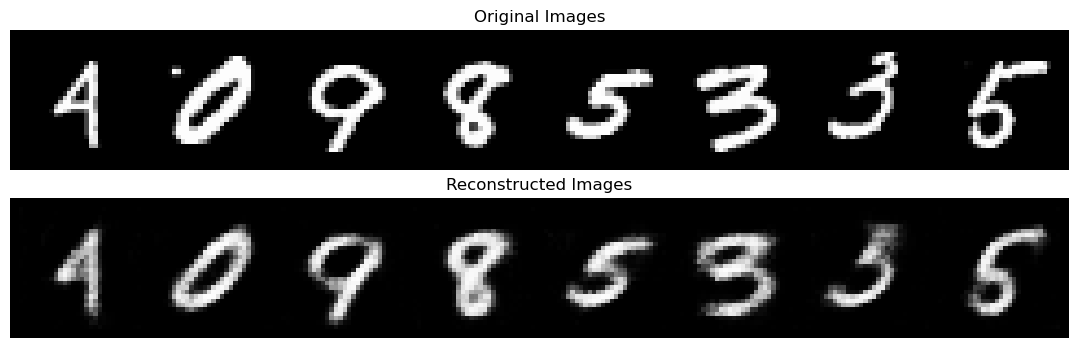

Epoch 2


g_loss: 0.806774377822876, d_loss: 1.42244291305542: 100%|██████████| 938/938 [01:27<00:00, 10.72it/s]   

Final Avg: g_loss: 0.8375120594430325, d_loss: 1.4280123089168117


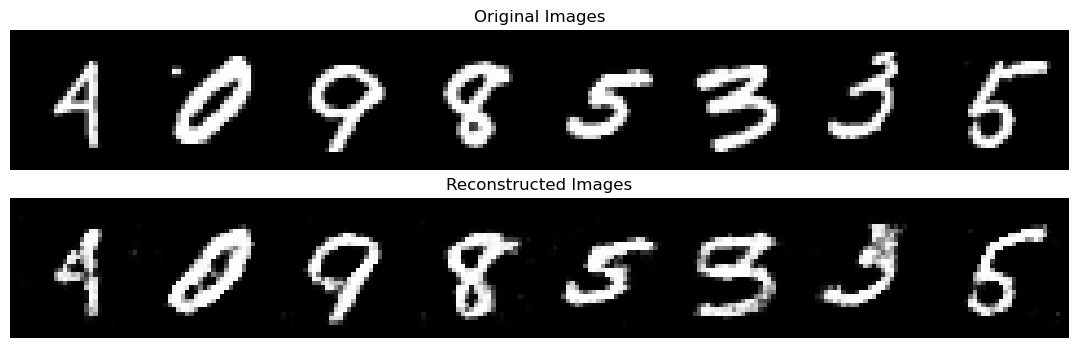

Epoch 3


g_loss: 0.7927603721618652, d_loss: 1.3932687044143677: 100%|██████████| 938/938 [01:27<00:00, 10.77it/s]

Final Avg: g_loss: 0.8222228198417468, d_loss: 1.399347552739735


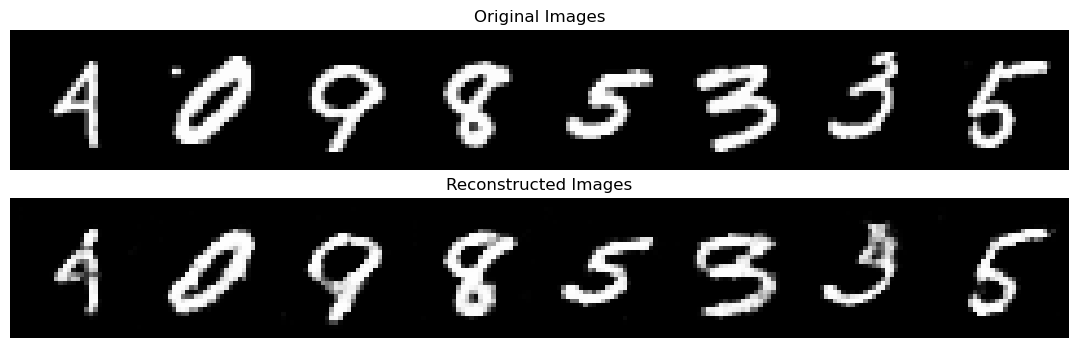

Epoch 4


g_loss: 0.8043383359909058, d_loss: 1.4142003059387207:  37%|███▋      | 348/938 [00:33<00:56, 10.53it/s]


KeyboardInterrupt: 

In [50]:
# total number of epochs to train the model
num_epochs = 10
# pre-train the encoder only
enc_warmup_epochs = 1

# Constant images for visualisation
test_imgs, test_labels = next(iter(dataloader))
test_imgs = test_imgs[:8].to(device)
test_labels = test_labels[:8].to(device)

# optimisers
lr=0.0002
ecgen_optimiser = torch.optim.Adam(ecgenerator.parameters(), lr=lr, betas=(0.5, 0.999))
ecdis_optimiser = torch.optim.Adam(ecdiscriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    # Avg epoch losses
    ecdis_loss_sum = 0 
    ecgen_loss_sum = 0
    enc_loss_sum = 0
    data_iter = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, labels) in data_iter:
        # Prepare batch 
        real_img = images.to(device)
        labels = labels.to(device)
        ecgenerator.train()
        batch_size = real_img.shape[0]

        # (opt) Pre-train encoder
        if epoch < enc_warmup_epochs:
            enc_loss = cond_enc_train_step(
                ecgenerator, ecgen_optimiser, loss_enc, real_img, labels
            )

            # Update running loss
            enc_loss_sum += enc_loss
            if i % 50 == 0:
                data_iter.set_description('enc_loss: {}'.format(enc_loss))

        # Train discriminator
        else:
            ecdis_loss = ecdis_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecdis_optimiser, loss, real_img, labels
                )
            
            ecgen_loss = ecgen_train_step(
                batch_size, ecgenerator, ecdiscriminator, ecgen_optimiser, loss, loss_enc, real_img,  labels
                )
            
            # Update running loss
            ecdis_loss_sum += ecdis_loss
            ecgen_loss_sum += ecgen_loss
            if i % 50 == 0:
                data_iter.set_description('g_loss: {}, d_loss: {}'.format(ecgen_loss, ecdis_loss))

    # average loss over epoch
    if epoch < enc_warmup_epochs:
        print(
            'Final Avg: enc_loss: {}'.format(
                enc_loss_sum / len(dataloader)
            )
        )
    else:
        print(
            'Final Avg: g_loss: {}, d_loss: {}'.format(
                ecgen_loss_sum / len(dataloader), ecdis_loss_sum / len(dataloader)
            )
        )
    
    ecgenerator.eval()

    # Visualise the progress of the model each epoch
    sample_images = ecgenerator(test_imgs, test_labels).cpu()
    fig, axs = plt.subplots(2, figsize=(16, 4))

    grid1 = torchvision.utils.make_grid(test_imgs.cpu(), nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[0].imshow(grid1)
    axs[0].axis("off")
    axs[0].set_title("Original Images")

    grid2 = torchvision.utils.make_grid(sample_images, nrow=8, padding=2, normalize=True).permute(1,2,0).numpy()
    axs[1].imshow(grid2)
    axs[1].axis("off")
    axs[1].set_title("Reconstructed Images")
    plt.show()